### Imports

In [1]:
from __future__ import print_function
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Lambda, Input, Subtract, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import tensorflow as tf
import h5py
import cv2
import numpy as np
import matplotlib; matplotlib.use('Agg')
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
from keras.backend.tensorflow_backend import set_session
from utils import limited_gpu_memory_session, get_available_gpus
set_session(limited_gpu_memory_session(0.95))
print(get_available_gpus())

[u'/gpu:0']


In [4]:
DATA_DIR = '/home/Drive2/rishabh/'
INIT_WEIGHTS = os.path.join(DATA_DIR, 'init_weights_omniglot.hdf5')
CHECKPOINTED_WEIGHTS = os.path.join(DATA_DIR, 'checkpointed_weights_omniglot.hdf5')

In [5]:
### Load the test and train datasets

In [6]:
from keras.preprocessing.image import ImageDataGenerator
image_width = 105
image_height = 105
image_size = (image_width, image_height)

datagen = ImageDataGenerator()

train_dir = os.path.join(DATA_DIR, 'omniglot_keras/images_background') # python/

train_generator = datagen.flow_from_directory(
        train_dir,  target_size=image_size,
        batch_size = 19280,
        class_mode='sparse', color_mode="grayscale",
        shuffle=True)

test_dir = os.path.join(DATA_DIR, 'omniglot_keras/images_evaluation')

test_generator = datagen.flow_from_directory(
        test_dir,  target_size=image_size, # this is the target directory
        batch_size = 13180, color_mode="grayscale",
        class_mode='sparse')

Found 19280 images belonging to 964 classes.
Found 13180 images belonging to 659 classes.


In [7]:
X_train, y_train = train_generator.next()
X_val, y_val = test_generator.next()

In [8]:
from utils import get_alphabet_to_index
val_alphabet_to_index = get_alphabet_to_index(test_generator)
train_alphabet_to_index = get_alphabet_to_index(train_generator)

In [9]:
to_plot = X_train[np.where(y_train == 0)[0]]
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.axis('off')
    plt.imshow(to_plot[i][:,:,0], cmap = 'gray', interpolation="nearest")

# Build the convolutional neural network

In [10]:
from keras.regularizers import l2
from keras.initializers import RandomNormal

W_init = RandomNormal(mean=0, stddev=1e-2) #'glorot_uniform'
b_init = RandomNormal(mean= 0.5, stddev=1e-2)
W_dense_init = RandomNormal(mean=0, stddev = 2e-1)

input_shape = (105, 105, 1)
reg, reg1 = 1e-3, 2e-3
#build convnet to use in each siamese 'leg'
convnet = Sequential(name="convnet")
convnet.add(Conv2D(64, (10,10), activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(reg)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128, (7,7), activation='relu', kernel_regularizer=l2(reg),
                   kernel_initializer=W_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init, bias_initializer=b_init, 
                   kernel_regularizer=l2(reg)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init, bias_initializer=b_init, 
                   kernel_regularizer=l2(reg)))
convnet.add(Flatten())
convnet.add(Dropout(0.5))
convnet.add(Dense(4096,activation="sigmoid", kernel_regularizer=l2(reg1),kernel_initializer=W_dense_init, 
                  bias_initializer=b_init, name = "embedding"))
print(convnet.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 64)        6464      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       262272    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 256)         524544    
__________

## Define the loss functions for the siamese and triplet network

In [11]:
def l2_norm(x):
    return K.sqrt(K.sum(K.square(x)))

MARGIN = 0.2
def triplet_loss(y_true, y_pred): # 
    return K.mean(K.maximum(0.0, y_pred + MARGIN) - y_true * 0, axis = -1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean((1 - y_true) * K.square(y_pred) +
                  y_true * K.square(K.maximum(margin - y_pred, 0)))

## Define the siamese network built using the conv net defined above

In [12]:
left_input = Input(input_shape, name="input_1")
encoded_l = convnet(left_input)
# with tf.device('/gpu:1'):
right_input = Input(input_shape, name="input_2")
encoded_r  = convnet(right_input)

# merge two encoded inputs with a distance metric
diff = Subtract(name="diff")([encoded_l,encoded_r])
both = Lambda(lambda x : K.abs(x), output_shape = lambda x: x, name="abs")(diff)
prediction = Dense(1, activation='sigmoid', bias_initializer = b_init, name="output")(both)

siamese_net = Model(inputs=[left_input, right_input],outputs=prediction, name="siamese_net")
siamese_net.summary()
os.system("rm {}".format(INIT_WEIGHTS))
siamese_net.save_weights(INIT_WEIGHTS)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 105, 105, 1)   0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 105, 105, 1)   0                                            
____________________________________________________________________________________________________
convnet (Sequential)             (None, 4096)          38947648    input_1[0][0]                    
                                                                   input_2[0][0]                    
____________________________________________________________________________________________________
diff (Subtract)                  (None, 4096)          0           convnet[1][0]           

In [13]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.8,
              patience=1, verbose = 1, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_acc',
                              min_delta=1e-4,
                              patience=25,
                              verbose=0, mode='auto')
checkpointer = ModelCheckpoint(filepath=CHECKPOINTED_WEIGHTS, verbose=1, save_best_only=True, monitor='oneshot_acc')

In [14]:
from keras.callbacks import Callback

class LossHistory(Callback):
    
    def __init__(self, X_val, y_val, alphabets={}):
        self.X_val = X_val
        self.y_val = y_val
        self.alphabets = alphabets
        self.matches = {}
        for x in np.unique(y_val):
            self.matches[x] = np.where(y_val == x)[0]
        self.true_indices = np.arange(20)
        self.one_shot_indices = list(self.one_shot_task(alph) for alph in self.alphabets)

    def on_epoch_end(self, epoch, logs={}):
        one_shot_acc = self.one_shot_acc()
        logs['oneshot_acc'] = one_shot_acc
        print(" oneshot_acc - {}".format(one_shot_acc))
        
    def one_shot_acc(self):
        acc = [self.compute_acc(index[0], index[1]) for index in self.one_shot_indices]
        return np.mean(acc)
    
    def compute_acc(self, support, test):
        X_support, X_test = self.X_val[support], self.X_val[test]
        class_indices = self.compute_pred_class(X_test, X_support)
        return (np.sum(class_indices == self.true_indices))/20.0

    def one_shot_task(self, alph):
        class_arr = self.alphabets[alph]
        sample_classes = np.random.choice(class_arr, 20, replace = False)
        train_arr, test_arr = [], []
        drawers = np.random.choice(20, 2, replace = False)
        support_arr = [self.matches[x][drawers[0]] for x in sample_classes] 
        test_arr = [self.matches[x][drawers[1]] for x in sample_classes]
        return (support_arr, test_arr)
        
    def kernel(self, x, y):
        return self.model.predict([x, y]).ravel()

    def compute_pred_class(self, X, Y):
        n = Y.shape[0]
        columns = (np.array([x] * n) for x in X)    
        pred_classes = np.array([np.argmax(self.kernel(col, Y)) for col in columns])
        return pred_classes

In [15]:
val_alphs = val_alphabet_to_index.keys()
val_partial = val_alphs[:len(val_alphs)//2]
val_one_shot = set([x for alp in val_partial for x in val_alphabet_to_index[alp]])

In [18]:
val_oneshot = [i for i in range(len(y_val)) if y_val[i] in val_one_shot]
val_train = [i for i in range(len(y_val)) if y_val[i] not in val_one_shot]

val_oneshot_index = {k : val_alphabet_to_index[k] for k in val_partial}
val_train_index = {k : v for k, v in val_alphabet_to_index.iteritems() if k not in val_partial}
loss_history = LossHistory(X_val[val_oneshot], y_val[val_oneshot], val_oneshot_index)

### Create the data generator to load batches of data

In [19]:
import utils; reload(utils)
from utils import DataGenerator

NUM_TRAIN_PAIRS = 150000
NUM_VAL_PAIRS = 10000
BATCH_SIZE = 128
datagen = DataGenerator(X_train, y_train, num_train_pairs = NUM_TRAIN_PAIRS,
                        num_val_pairs = NUM_VAL_PAIRS, X_val = X_val[val_train],
                        train_alphabet_to_index = train_alphabet_to_index,
                        val_alphabet_to_index = val_train_index,
                        y_val = y_val[val_train], batch_sz = BATCH_SIZE, verbose = True)
datagen.create_data_transformer(rotation_range=10, width_shift_range=0.01, 
                              height_shift_range=0.01, shear_range=0.01)

Generating Training Pairs..
Generating Validation Pairs..


In [20]:
STEPS_PER_EPOCH = NUM_TRAIN_PAIRS // BATCH_SIZE
VALIDATION_STEPS = NUM_VAL_PAIRS // BATCH_SIZE 

In [37]:
from keras.optimizers import Adam, SGD
learning_rate = 5e-3
# adam = Adam(learning_rate)
sgd = SGD(lr=learning_rate, decay=5e-3, momentum=0.9, nesterov=True)
# scheduler = LearningRateScheduler(lambda epoch : learning_rate * pow(1.02, epoch))

In [35]:
siamese_net.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
siamese_net.load_weights(INIT_WEIGHTS)
# siamese_net.load_weights(CHECKPOINTED_WEIGHTS)

In [51]:
WEIGHTS_PATH = "/home/rishabh/siamese/keras-oneshot/weights"
# siamese_net.load_weights(WEIGHTS_PATH)

In [38]:
history = siamese_net.fit_generator(
        datagen.next_train(),
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=500,
        validation_data = datagen.next_val(),
        validation_steps = VALIDATION_STEPS,
        callbacks = [reduce_lr, early_stopping, loss_history, checkpointer])

Epoch 1/500
1170/1171 [============================>.] - ETA: 0s - loss: 7.0108 - acc: 0.5005 oneshot_acc - 0.05
Epoch 00000: oneshot_acc did not improve
1171/1171 [==============================] - 164s - loss: 7.0100 - acc: 0.5005 - val_loss: 6.1181 - val_acc: 0.4998
Epoch 2/500
1170/1171 [============================>.] - ETA: 0s - loss: 5.4362 - acc: 0.5000 oneshot_acc - 0.05
Epoch 00001: oneshot_acc did not improve
1171/1171 [==============================] - 165s - loss: 5.4356 - acc: 0.5000 - val_loss: 4.8326 - val_acc: 0.5008
Epoch 3/500
1170/1171 [============================>.] - ETA: 0s - loss: 4.3589 - acc: 0.4973 oneshot_acc - 0.05
Epoch 00002: oneshot_acc did not improve
1171/1171 [==============================] - 165s - loss: 4.3585 - acc: 0.4974 - val_loss: 3.9346 - val_acc: 0.5001
Epoch 4/500
1170/1171 [============================>.] - ETA: 0s - loss: 3.5942 - acc: 0.4991
Epoch 00003: reducing learning rate to 0.0255999982357.
 oneshot_acc - 0.05
Epoch 00003: oneshot

 oneshot_acc - 0.05
Epoch 00025: oneshot_acc did not improve
1171/1171 [==============================] - 165s - loss: 2.0397 - acc: 0.4993 - val_loss: 2.0394 - val_acc: 0.4996
Epoch 27/500
1170/1171 [============================>.] - ETA: 0s - loss: 2.0391 - acc: 0.4994
Epoch 00026: reducing learning rate to 0.000151115725748.
 oneshot_acc - 0.05
Epoch 00026: oneshot_acc did not improve
1171/1171 [==============================] - 165s - loss: 2.0391 - acc: 0.4993 - val_loss: 2.0388 - val_acc: 0.4999
Epoch 28/500
1170/1171 [============================>.] - ETA: 0s - loss: 2.0386 - acc: 0.4998
Epoch 00027: reducing learning rate to 0.000120892585255.
 oneshot_acc - 0.05
Epoch 00027: oneshot_acc did not improve
1171/1171 [==============================] - 165s - loss: 2.0386 - acc: 0.4999 - val_loss: 2.0384 - val_acc: 0.4985


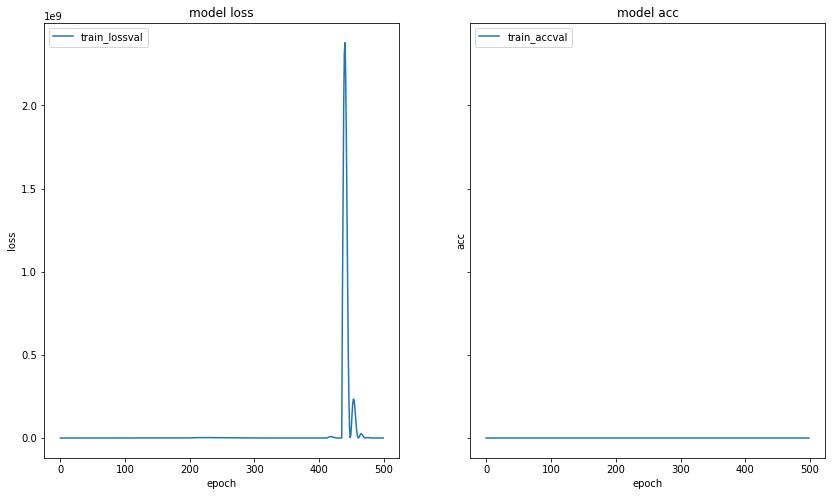

In [33]:
% matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(8)
f.set_figwidth(14)

ax1.plot(history.history['loss'])
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train_loss' 'val'], loc='upper left')

ax2.plot(history.history['acc'])
# ax2.plot(history.history['val_acc'])
ax2.set_title('model acc')
ax2.set_ylabel('acc')
ax2.set_xlabel('epoch')
ax2.legend(['train_acc' 'val'], loc='upper left')

f.savefig('siamese_omniglot.png')

In [ ]:
siamese_net.load_weights(CHECKPOINTED_WEIGHTS)
for layer in siamese_net.layers:
    layer.trainable = False
siamese_net.summary()
siamese_net.save(os.path.join(DATA_DIR, 'siamese_omniglot1.h5'))

In [ ]:
from keras.models import load_model
siamese_net = load_model(os.path.join(DATA_DIR, 'siamese_omniglot.h5'))
siamese_net.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = siamese_net.evaluate_generator(datagen.next_val(),
        steps=VALIDATION_STEPS)
print("Loss {} Accuracy {}".format(history[0], history[1]))